In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    mean_squared_error, 
    roc_auc_score, 
    f1_score, 
    accuracy_score,
    confusion_matrix,
    classification_report
)
import optuna
import lightgbm as lgb
# import xgboost as xgb
# from catboost import CatBoostClassifier, Pool
import warnings
warnings.filterwarnings('ignore')

# 再現性のためのシード設定
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [6]:
train_df = pd.read_csv("/home/takato/bita/bank/data/train.csv")
test_df = pd.read_csv("/home/takato/bita/bank/data/test.csv")

In [ ]:
def feature_engineering(df, is_train=True, encoders=None):
    """
    特徴量エンジニアリング関数
    
    Parameters:
    -----------
    df : DataFrame
        処理対象のデータフレーム
    is_train : bool
        訓練データの場合True、テストデータの場合False
    encoders : dict
        テストデータ処理時に使用するエンコーダー辞書
        {'target_encoders': {...}, 'label_encoders': {...}, 'freq_encoders': {...}, 'age_bins': [...]}
    
    Returns:
    --------
    df : DataFrame
        特徴量エンジニアリング済みのデータフレーム
    encoders : dict or None
        訓練時はエンコーダー辞書を返す、テスト時はNone
    """
    df = df.copy()
    
    # 1. 数値特徴量の変換
    # 年齢グループ（スタージェスの公式を使用）
    # k = 1 + log2(n) = 1 + 3.322 * log10(n)
    if is_train:
        n = len(df)
        k = int(1 + 3.322 * np.log10(n))  # スタージェスの公式
        # pd.cutで等間隔にビンを作成し、ビンの境界を保存
        df['age_group'], age_bins = pd.cut(df['age'], bins=k, retbins=True, duplicates='drop')
    else:
        # テストデータでは訓練時のビンを使用
        if encoders is None or 'age_bins' not in encoders:
            raise ValueError("テストデータ処理時にはage_binsが必要です")
        df['age_group'] = pd.cut(df['age'], bins=encoders['age_bins'], duplicates='drop')
    
    # balance の対数変換（負の値があるため調整）
    df['balance_log'] = np.log1p(df['balance'] - df['balance'].min() + 1)
    
    # 2. 時系列特徴量
    # dayとduration の比率
    df['duration_per_day'] = df['duration'] / (df['day'] + 1)
    
    # campaign効率
    df['campaign_efficiency'] = df['duration'] / (df['campaign'] + 1)
    
    # previous の成功率（pdaysが999でない場合）
    df['has_previous_contact'] = (df['pdays'] != 999).astype(int)
    df['previous_success_rate'] = df['previous'] / (df['pdays'].replace(999, 1) + 1)
    
    # 3. 月のマッピング
    month_mapping = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
        'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
        'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }

    # 数値変換
    df['month_numeric'] = df['month'].map(month_mapping)

    # 周期性エンコーディング
    df['month_sin'] = np.sin(2 * np.pi * df['month_numeric'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month_numeric'] / 12)

    df = df.drop(columns=['month','month_numeric'])
    
    # 4. ローン関連の特徴量
    df['total_loans'] = (df['housing'] == 'yes').astype(int) + (df['loan'] == 'yes').astype(int)
    df['has_any_loan'] = (df['total_loans'] > 0).astype(int)
    
    # 5. カテゴリカル変数のリスト
    categorical_feats = ['job', 'marital', 'education', 'contact', 'poutcome', 'age_group']
    zero_and_one_list = ['default', 'housing','loan']
    for col in zero_and_one_list:
        df[col] = df[col].map({'yes': 1, 'no': 0})
    
    if is_train:
        # 訓練データ：エンコーダーを作成
        target_encoders = {}
        label_encoders = {}
        freq_encoders = {}
        
        # 6. Target Encoding（訓練データのみで学習）
        for col in categorical_feats:
            if 'y' in df.columns:
                target_mean = df.groupby(col)['y'].mean()
                # Smoothingを適用
                global_mean = df['y'].mean()
                counts = df.groupby(col).size()
                smoothing = 10
                smooth_target = (target_mean * counts + global_mean * smoothing) / (counts + smoothing)
                target_encoders[col] = smooth_target
                df[f'{col}_target_enc'] = df[col].map(smooth_target)
        
        # 7. Frequency Encoding
        for col in categorical_feats:
            freq = df[col].value_counts(normalize=True)
            freq_encoders[col] = freq
            df[f'{col}_freq'] = df[col].map(freq)
        
        # 8. Label Encoding（訓練時に学習）
        for col in categorical_feats:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
        
        # エンコーダーをまとめて返す（age_binsも含める）
        encoders = {
            'target_encoders': target_encoders,
            'label_encoders': label_encoders,
            'freq_encoders': freq_encoders,
            'age_bins': age_bins
        }
        return df, encoders
    
    else:
        # テストデータ：訓練時のエンコーダーを使用
        if encoders is None:
            raise ValueError("テストデータ処理時にはencodersを渡す必要があります")
        
        target_encoders = encoders['target_encoders']
        label_encoders = encoders['label_encoders']
        freq_encoders = encoders['freq_encoders']
        
        # 6. Target Encoding（訓練時の値を使用）
        for col in categorical_feats:
            if col in target_encoders:
                df[f'{col}_target_enc'] = df[col].map(target_encoders[col])
                # 未知のカテゴリには平均値を使用
                # 修正後（明示的にfloat型に変換）
                df[f'{col}_target_enc'] = df[f'{col}_target_enc'].astype('float64')
                df[f'{col}_target_enc'].fillna(target_encoders[col].mean(), inplace=True)
        
        # 7. Frequency Encoding（訓練時の頻度を使用）
        for col in categorical_feats:
            if col in freq_encoders:
                df[f'{col}_freq'] = df[col].map(freq_encoders[col])
                # 未知のカテゴリには最小頻度を使用
                df[f'{col}_freq'].fillna(freq_encoders[col].min(), inplace=True)
        
        # 8. Label Encoding（訓練時のエンコーダーを使用）
        for col in categorical_feats:
            if col in label_encoders:
                le = label_encoders[col]
                # 未知のカテゴリを処理
                df[col] = df[col].astype(str).apply(
                    lambda x: le.transform([x])[0] if x in le.classes_ else -1
                )
        
        return df, None

# 特徴量エンジニアリングを適用
train_processed, encoders = feature_engineering(train_df, is_train=True)
print("Feature engineering completed!")
print(f"New train shape: {train_processed.shape}")
print(f"Sturges' formula: k = {len(encoders['age_bins']) - 1} bins")
print(f"Age bins: {encoders['age_bins']}")

In [ ]:
# ターゲットと特徴量の分離
y = train_processed['y']
exclude_cols = ['id', 'y']
X = train_processed.drop(columns=exclude_cols)

print(f"Features: {X.shape[1]}")
print(f"\nFeature names: {list(X.columns)}")

# Train/Valid分割
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Valid set: {X_valid.shape}")

Features: 53

Feature names: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'age_group', 'balance_log', 'duration_per_day', 'campaign_efficiency', 'has_previous_contact', 'previous_success_rate', 'job_education', 'marital_education', 'contact_month', 'total_loans', 'has_any_loan', 'job_target_enc', 'marital_target_enc', 'education_target_enc', 'default_target_enc', 'housing_target_enc', 'loan_target_enc', 'contact_target_enc', 'month_target_enc', 'poutcome_target_enc', 'age_group_target_enc', 'job_education_target_enc', 'marital_education_target_enc', 'contact_month_target_enc', 'job_freq', 'marital_freq', 'education_freq', 'default_freq', 'housing_freq', 'loan_freq', 'contact_freq', 'month_freq', 'poutcome_freq', 'age_group_freq', 'job_education_freq', 'marital_education_freq', 'contact_month_freq']

Train set: (21702, 53)
Valid set: (5426, 53)


In [4]:
def objective_lgb(trial):
    """
    LightGBMのハイパーパラメータ最適化
    """
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
        "n_estimators": 2000,
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "random_state": RANDOM_STATE,
        "class_weight": "balanced"  # 不均衡データ対応
    }
    
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.early_stopping(100, verbose=False)]
    )
    
    preds = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, preds)
    return auc

# 最適化実行（より多くのトライアル）
study_lgb = optuna.create_study(direction="maximize")
study_lgb.optimize(objective_lgb, n_trials=100, show_progress_bar=True)

print("Best AUC (LightGBM):", study_lgb.best_value)
print("Best params (LightGBM):", study_lgb.best_params)

[I 2025-11-10 01:43:08,831] A new study created in memory with name: no-name-fe4a4ec0-df7b-4799-ac92-bdeb23743ffd
  0%|          | 0/100 [00:00<?, ?it/s]

[W 2025-11-10 01:43:08,836] Trial 0 failed with parameters: {'learning_rate': 0.005188273291026315, 'num_leaves': 157, 'max_depth': 8, 'min_child_samples': 31, 'subsample': 0.6175976714521517, 'colsample_bytree': 0.8859099958461962, 'reg_alpha': 1.8556397869670388e-08, 'reg_lambda': 0.010841856920568778, 'min_split_gain': 0.5723194206087475} because of the following error: NameError("name 'X_train' is not defined").
Traceback (most recent call last):
  File "/home/takato/bita/bank/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_20993/2509963719.py", line 25, in objective_lgb
    X_train, y_train,
    ^^^^^^^
NameError: name 'X_train' is not defined
[W 2025-11-10 01:43:08,839] Trial 0 failed with value None.


NameError: name 'X_train' is not defined

In [15]:
best_params_lgb = study_lgb.best_params
best_params_lgb.update({
    "n_estimators": 2000,
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "random_state": RANDOM_STATE,
    "class_weight": "balanced"
})
model_lgb = lgb.LGBMClassifier(**best_params_lgb)
model_lgb.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    callbacks=[lgb.early_stopping(100, verbose=False)]
)


,boosting_type,'gbdt'
,num_leaves,63
,max_depth,13
,learning_rate,0.02108363741201037
,n_estimators,2000
,subsample_for_bin,200000
,objective,'binary'
,class_weight,'balanced'
,min_split_gain,0.15647668518325442
,min_child_weight,0.001
,min_child_samples,47


In [20]:
pred_lgb

array([0.00219903, 0.01776736, 0.01218878, ..., 0.55576381, 0.19480137,
       0.13786023], shape=(5426,))

In [21]:
# 各モデルの予測確率
pred_lgb = model_lgb.predict_proba(X_valid)[:, 1]
auc_lgb = roc_auc_score(y_valid, pred_lgb)

# 閾値を最適化してF1スコアを計算
from sklearn.metrics import f1_score
best_threshold = 0.5
best_f1 = 0
for threshold in np.arange(0.3, 0.7, 0.01):
    pred_binary = (pred_lgb > threshold).astype(int)
    f1 = f1_score(y_valid, pred_binary)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nBest threshold: {best_threshold:.3f}")
print(f"Best F1 Score: {best_f1:.5f}")


Best threshold: 0.690
Best F1 Score: 0.62634


In [19]:
pred_binary

np.int64(1)

In [29]:
encoders['target_encoders']['job'].mean()

np.float64(0.13455968736562965)

In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21702 entries, 26040 to 22488
Data columns (total 53 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   age                           21702 non-null  int64   
 1   job                           21702 non-null  int64   
 2   marital                       21702 non-null  int64   
 3   education                     21702 non-null  int64   
 4   default                       21702 non-null  int64   
 5   balance                       21702 non-null  int64   
 6   housing                       21702 non-null  int64   
 7   loan                          21702 non-null  int64   
 8   contact                       21702 non-null  int64   
 9   day                           21702 non-null  int64   
 10  month                         21702 non-null  int64   
 11  duration                      21702 non-null  int64   
 12  campaign                      21702 non-null  i

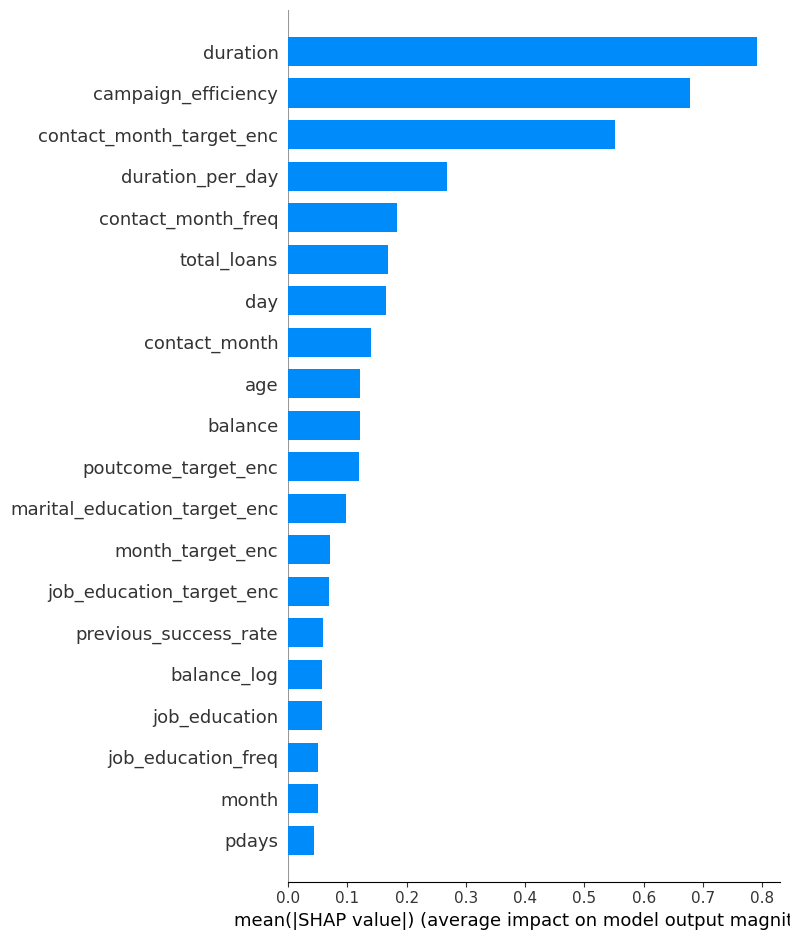

In [53]:
import shap
# 各サンプル × 各特徴の SHAP 値
shap_values = model_lgb.predict(X_valid, pred_contrib=True)

# shap_valuesは numpy配列（shape: [n_samples, n_features + 1])
# 最後の列は "bias term"（全体平均予測値）
shap_values = shap_values[:, :-1]  # bias列を除外

shap.summary_plot(shap_values, X_valid, plot_type="bar")
plt.show()

In [50]:
# テストデータに特徴量エンジニアリングを適用
test_processed, _ = feature_engineering(test_df, is_train=False, encoders=encoders)

# # 特徴量の抽出
X_test = test_processed.drop(columns=['id'])
X_test['age_group_target_enc'] = X_test['age_group_target_enc'].astype('category')

# 各モデルで予測
test_pred_lgb = model_lgb.predict_proba(X_test)[:, 1]




In [52]:
# 最適閾値で二値化
test_pred_final = (test_pred_lgb > best_threshold).astype(int)

# 結果を保存
submission = pd.DataFrame({
    'id': test_df['id'],
    'y': test_pred_final
})

submission.to_csv('/home/takato/bita/bank/data/high_accuracy_submission.csv', index=False, header=False)